In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from tqdm.auto import tqdm, trange

In [3]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset

σ = torch.sigmoid

from sklearn.model_selection import train_test_split

In [15]:
# device = torch.device("mps")
device = torch.device("cpu")

In [16]:
import sys
sys.path.append("../src/")

from iou import find_split_indices, calculate_metrics
from utils import proba2class, standardize, label_smoothing

In [17]:
from sklearn.metrics import euclidean_distances

# Dataset

## Synthetic

In [18]:
filename = "../data/synthetic-latest.csv"
df = pd.read_csv(
    filename,
    # nrows=int(2**14)  # debug
)

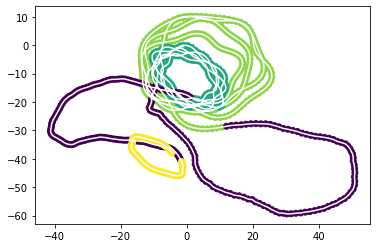

In [19]:
df_draw = df[:1_000]
plt.plot(df_draw.x, df_draw.y, "w")
plt.scatter(df_draw.x, df_draw.y, c=df_draw.period)

In [20]:
class Dataset2D(Dataset):
    
    def __init__(
        self,
        df,
        window_size=256,
        window_step=128,
        train=False
    ):
        
        self.df = df.copy()
        self.window_size = window_size
        self.window_step = window_step
        self.train = train
        
        self.indices = list(range(
            0,
            len(self.df) + 1 - self.window_size,
            self.window_step
        ))
        
    def create_sample(self, df, α=1.1):

        n = len(df)
        xyz = ["x", "y", "z"]
                
        image = euclidean_distances(df[xyz])
        # image /= image.max()
        image /= 100
        
        counts = df.period.value_counts()
        counts = (counts * 10 / counts.index > α) & (counts.index > 0)
        
        mask = np.zeros((n, n))
        for p in df.period.unique():
            if p == 0:
                continue
            if not counts[p]:
                continue
            m = (df.period == p).astype(float)
            m = np.tile(m, (len(m), 1))
            m = m * m.T
            mask = mask + m
            
        return image, mask
                        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        
        # i1 = np.random.randint(len(self.df) - self.window_size)
        # i2 = i1 + self.window_size
        
        i1 = self.indices[idx]
        i2 = i1 + self.window_size
        
        df_slice = self.df[i1: i2]
        
        if self.train and (np.random.rand() > 0.5):
            df_slice = df_slice[::-1]
        
        x, y = self.create_sample(df_slice)
        
        x = torch.from_numpy(x).float().unsqueeze(0)
        y = torch.from_numpy(y).float().unsqueeze(0)
        
        return x, y

In [31]:
i_train = len(df) * 8 // 10
WINDOW_SIZE = 512
WINDOW_STEP = WINDOW_SIZE // 2
dataset_train = Dataset2D(
    df[:i_train],
    window_size=WINDOW_SIZE,
    window_step=WINDOW_STEP,
    train=True
)

dataset_test = Dataset2D(
    df[i_train:],
    window_size=WINDOW_SIZE,
    window_step=WINDOW_STEP
)

In [32]:
len(dataset_train)

474

In [33]:
x, y = dataset_train[2]

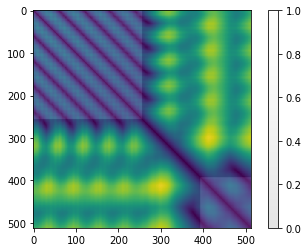

In [34]:
plt.imshow(x[0], interpolation="none")
plt.imshow(y[0], alpha=0.1, cmap="Greys_r")
plt.colorbar()

In [35]:
batch_size = 16  # len(dataset_train) // 100
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Model

In [37]:
from UNet import UNet

In [38]:
model = UNet(1, 1, hidden_channels=4)
model.eval;
# summary(model, (1, 512, 512))

In [39]:
x = torch.rand(2, 1, 512, 512).to(device)

In [44]:
%%timeit
y = model(x)

123 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
class DiceLoss(nn.Module):
    def __init__(self, logit=True):
        super(DiceLoss, self).__init__()
        self.logit = logit

    def forward(self, inputs, targets, smooth=1):

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        if self.logit:
            inputs = σ(inputs)
        
        intersection = (inputs * targets).sum()                            
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
    
class ComboLoss(nn.Module):
    def __init__(self, α=0., bce_weight=0.5):
        super(ComboLoss, self).__init__()
        self.dice = DiceLoss(logit=True)
        self.bce = nn.BCEWithLogitsLoss()
        self.α = α
        self.bce_weight = bce_weight
        self.dice_weight = 1 - bce_weight
        
    def forward(self, inputs, targets, ϵ=1):
        loss_dice = self.dice(inputs, targets)
        
        inputs = label_smoothing(targets, self.α)
        loss_bce = self.bce(inputs.view(-1), targets.view(-1)) 
        
        assert not torch.isnan(loss_dice)
        assert not torch.isnan(loss_bce)
        
        loss = self.bce_weight * loss_bce + self.dice_weight * loss_dice
        return loss

In [46]:
calculate_loss = ComboLoss(α=0.1, bce_weight=0.5)

In [47]:
model = UNet(1, 1, hidden_channels=4)

# device = torch.device("mps")
device = torch.device("cpu")

model = model.to(device)

In [48]:
x, y = dataset_test[10]
x = x.to(device)
y = y.to(device)

In [49]:
y_pred = model(x.unsqueeze(0))

In [50]:
calculate_loss = nn.BCEWithLogitsLoss()

In [51]:
calculate_loss(y_pred, y.unsqueeze(0))

tensor(0.8426, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [52]:
def bce(pred, true, ϵ=1e-6):
    pred = σ(pred)
    loss = (1 - true) * torch.log(1 - pred + ϵ) + true * torch.log(pred + ϵ)
    return -loss.mean()

In [53]:
bce(y_pred, y.unsqueeze(0))

tensor(0.8426, grad_fn=<NegBackward0>)

In [54]:
# calculate_loss = bce

In [55]:
def accuracy(pred, true):
    
    pred = pred.cpu()
    true = true.cpu()
        
    with torch.no_grad():
        pred = σ(pred) > 0.5
        
    score = torch.mean(((pred > 0.5) == (true > 0.5)).float())    
    
    return score.item()

In [56]:
# calculate_metrics(
#     proba2class(y_pred.view(-1)).detach().numpy(),
#     proba2class(y.view(-1)).detach().numpy()
# )[0]

# Train

In [57]:
def train_model(model, dataloader):
    
    loss_sum = 0
    score_sum = 0
    
    model.train()

    for X, Y in tqdm(dataloader):
        
        X = X.to(device)
        Y = Y.to(device)  
        
        optimizer.zero_grad()
        
        Y_pred = model.forward(X)
        
        assert not torch.isnan(Y_pred).any()
        
        # Y_pred = Y_pred.view(-1)
        # Y = Y.view(-1)
        
        # Y_pred_T = Y_pred.transpose(-2, -1).contiguous()          
        # loss = calculate_loss(Y_pred, Y) + calculate_loss(Y_pred_T, Y)
        # loss /= 2
        
        # return Y_pred, Y

        loss = calculate_loss(Y_pred, Y)
        
        assert not np.isnan(loss.item())
            
        loss.backward()
        
        optimizer.step()

        score = accuracy(Y_pred, Y)
        
        loss_sum += loss.item()
        score_sum += score
        
    loss = loss_sum / len(dataloader)
    score = score_sum / len(dataloader)
        
    return loss, score

In [58]:
def test_model(model, dataloader):
    
    loss_sum = 0
    score_sum = 0
    
    metrics_all = []
    n_diffs = []
    
    with torch.no_grad():

        model.eval()
        
        for X, y_true in tqdm(dataloader):
            
            X = X.to(device)
            y_true = y_true.to(device)  
            y_pred = model(X)
            
            # y_pred_T = y_pred.transpose(-2, -1).contiguous()
            # loss = calculate_loss(y_pred, y_true) + calculate_loss(y_pred_T, y_true)
            # loss /= 2
            
            loss = calculate_loss(y_pred, y_true)
            
            score = accuracy(y_pred, y_true)
            
            loss_sum += loss.item()
            score_sum += score
            
#             for pred, true in zip(y_pred, y_true):
                                
#                 metrics, df_metrics = calculate_metrics(
#                     proba2class(pred.view(-1)).detach().numpy(),
#                     proba2class(true.view(-1)).detach().numpy()
#                 )
                
#                 if metrics is None:
#                     continue
                
#                 metrics_all.append(df_metrics)
#                 n_diffs.append(metrics["n_diff"])
                
    loss = loss_sum / len(dataloader)
    score = score_sum / len(dataloader)
    
    # metrics_all = pd.concat(metrics_all)
    # metrics = metrics_all.mean().to_dict()
    # metrics["n_diff"] = np.mean(n_diffs)
        
    return loss, score, None # metrics

In [59]:
def train_epoch(model, optimizer):
    
    objectives = {}
    
    # Train
    
    loss, score = train_model(
        model,
        train_dataloader
    )
        
    objectives["loss_train"] = loss
    objectives["score_train"] = score
    
    # Test

    loss, score, metrics = test_model(
        model,
        test_dataloader
    )
    objectives["loss_test"] = loss
    objectives["score_test"] = score
    
    # objectives.update(metrics)

    return objectives

# Train

In [60]:
device = torch.device("cpu")
# device = torch.device("mps")

In [61]:
model = UNet(1, 1, hidden_channels=4)
model = model.to(device)

rows_progress = []
score_test_best = 0.

In [62]:
# calculate_loss = DiceLoss()
calculate_loss = ComboLoss(α=0.1)
# calculate_loss = nn.BCEWithLogitsLoss()
# calculate_loss = bce

In [63]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-2
)

In [64]:
# pred, true = train_model(model, train_dataloader)

In [84]:
filename_model_save = "../models/rad-v3.0-arkit-latest.st"

with trange(10) as t:
    for epoch in t:
        
        objectives = train_epoch(model, optimizer)
            
        rows_progress.append(objectives)
        
        score_test = objectives["score_test"]
        if score_test > score_test_best:
            score_test_best = score_test
            # torch.save(model.state_dict(), filename_model_save)

        t.set_postfix(
            train=objectives["score_train"],
            test=score_test,
            best=score_test_best
        )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [85]:
df_progress = pd.DataFrame(rows_progress)

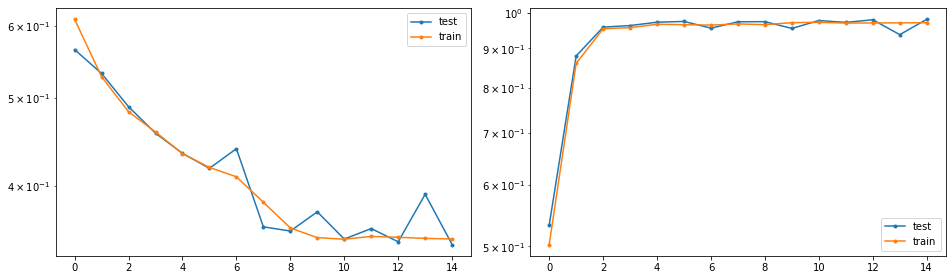

In [86]:
fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(0.3))

for i, key in enumerate(["loss", "score"]):

    ax = axes[i]
    plt.sca(ax)

    for t in "test", "train":
        plt.plot(df_progress[f"{key}_{t}"], ".-", label=t)

    plt.legend()
    plt.yscale("log")

plt.tight_layout()

In [197]:
len(dataset_test)

117

In [324]:
x, y = dataset_test[108]
x = x.to(device)
y = y.to(device)

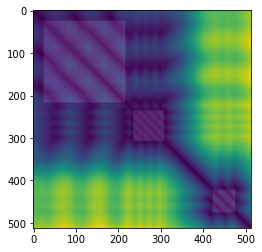

In [325]:
plt.imshow(x[0].cpu())
plt.imshow(y[0].cpu(), alpha=0.1, cmap="Greys_r")

In [326]:
with torch.no_grad():
    y_pred = model(x.unsqueeze(0))
    
output = σ(y_pred.squeeze()).cpu()

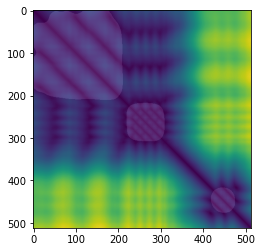

In [327]:
plt.imshow(x[0].cpu())
plt.imshow(output.cpu() > 0.5, alpha=0.1, cmap="Greys_r")

In [328]:
A = (output + output.T) / 2

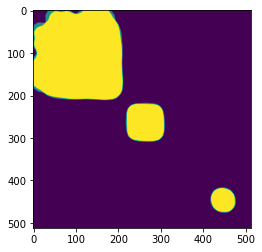

In [329]:
plt.imshow(A)

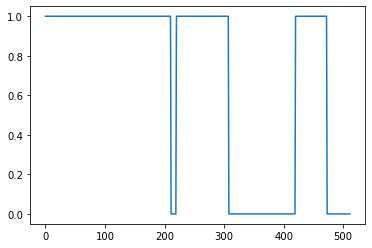

In [330]:
plt.plot(A.mean(0) > 0.05)

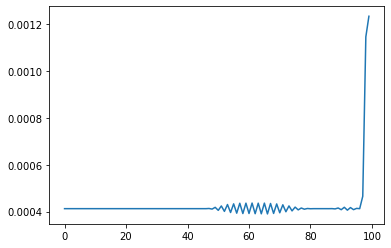

In [315]:
plt.plot(output[10, -100:])

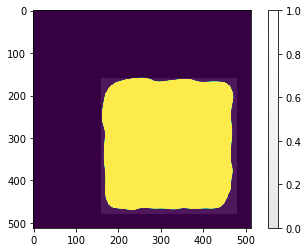

In [208]:
plt.imshow(output, vmin=0, vmax=1, interpolation="none")
plt.imshow(output > 0.5, vmin=0, vmax=1, cmap="Greys_r", alpha=0.1, interpolation="none")
plt.imshow(y[0].cpu(), alpha=0.1, cmap="Greys_r")
plt.colorbar()

In [211]:
from scipy.interpolate import interp1d

In [283]:
# folder = "/Volumes/samsung-T5/HPL/Rheeda/pipeline/M15/G3/S15/trajectories"
# folder = "/Volumes/samsung-T5/HPL/Rheeda/pipeline/M13/G3/S13/trajectories"
folder = "/Volumes/samsung-T5/HPL/Rheeda/pipeline/M15/G3/S39/trajectories"
# folder = "/Volumes/samsung-T5/HPL/Rheeda/pipeline/M15/G2/S01/trajectories"

filenames = os.listdir(folder)

dfs = []

for i, filename in enumerate(filenames[:]):
    
    filename = os.path.join(folder, filename)
    df = pd.read_csv(filename)
    if df.t.max() < 2500.:
        continue
        
    df["i"] = i
        
    dfs.append(df)
    
    break

In [284]:
xyz = ["x", "y", "z"]

dfs_interp = []

for df in dfs:
    f = interp1d(df.t, df[xyz], axis=0)
    t = np.arange(df.t.min(), df.t.max(), 10)
    X = f(t)
    
    df_interp = pd.DataFrame(X, columns=xyz)
    df_interp["t"] = t
    dfs_interp.append(df_interp)

In [285]:
traj = df_interp.copy()

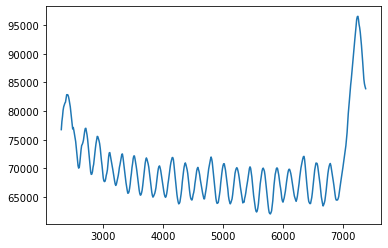

In [286]:
plt.plot(traj.t, traj.x)

In [287]:
xyz = ["x", "y", "z"]

image = euclidean_distances(traj[xyz])
# image /= image.max()
image /= (100 * 1000)

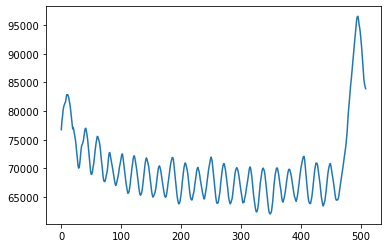

In [288]:
plt.plot(traj.x)

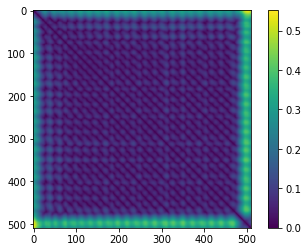

In [289]:
plt.imshow(image)
plt.colorbar()

In [290]:
x = torch.from_numpy(image).float()

In [291]:
with torch.no_grad():
    pred = σ(model(x.unsqueeze(0).unsqueeze(0))).squeeze()

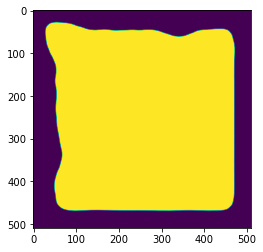

In [292]:
plt.imshow(pred)

In [293]:
A = (pred + pred.T) / 2

In [294]:
A.shape

torch.Size([509, 509])

In [295]:
A = (pred + pred.T) / 2
pred = (A.mean(0) > 0.1).float()

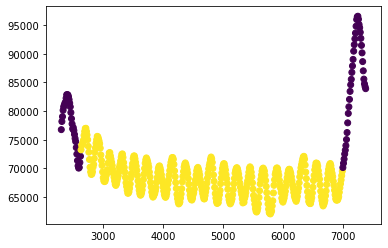

In [296]:
plt.scatter(traj.t, traj.x, c=pred)